# Phase 3

In [1]:
import numpy as np
import pandas as pd
import joblib
import time
import os

In [3]:
# --- CONFIGURATION ---
BASE_DIR = r"C:\Users\ayber\OneDrive\Masaüstü\ML"
DATA_PATH = os.path.join(BASE_DIR, "Data/processed/irb2400_ready.csv.gz")
MODEL_PATH = os.path.join(BASE_DIR, "Models/mlp_baseline.pkl")
SCALER_X_PATH = os.path.join(BASE_DIR, "Models/scaler_x.pkl")
SCALER_Y_PATH = os.path.join(BASE_DIR, "Models/scaler_y.pkl")

In [4]:
# --- KINEMATICS ENGINE ---
class IRB2400_Kinematics:
    def __init__(self):
        # ... existing parameters ...
        self.d1 = 0.615
        self.a1 = 0.100
        self.a2 = 0.705
        self.a3 = 0.0315
        self.d4 = 0.755
        self.d6 = 0.1547
        self.offsets = [0, 0, 180, 0, 0, 0]
        
        # JOINT LIMITS (Standard IRB 2400)
        # Used to verify if solution is valid
        self.limits = [
            (-180, 180), # q1
            (-100, 110), # q2
            (-60, 65),   # q3 (Check manual for exact values)
            (-200, 200), # q4
            (-120, 120), # q5
            (-400, 400)  # q6
        ]

    # ... existing _dh_matrix and forward_kinematics methods ...
    def _dh_matrix(self, theta, d, a, alpha):
        t = np.radians(theta)
        alp = np.radians(alpha)
        c, s = np.cos(t), np.sin(t)
        ca, sa = np.cos(alp), np.sin(alp)
        return np.array([
            [c, -s*ca, s*sa, a*c],
            [s, c*ca, -c*sa, a*s],
            [0, sa,    ca,   d],
            [0, 0,     0,    1]
        ])

    def forward_kinematics(self, joints_deg):
        q = np.array(joints_deg) + np.array(self.offsets)
        T01 = self._dh_matrix(q[0], self.d1, self.a1, -90)
        T12 = self._dh_matrix(q[1], 0,       self.a2, 0)
        T23 = self._dh_matrix(q[2], 0,       self.a3, -90)
        T34 = self._dh_matrix(q[3], self.d4, 0,       90)
        T45 = self._dh_matrix(q[4], 0,       0,       -90)
        T56 = self._dh_matrix(q[5], self.d6, 0,       0)
        T_total = T01 @ T12 @ T23 @ T34 @ T45 @ T56
        return T_total[:3, 3]

    def get_jacobian(self, joints_deg):
        epsilon = 1e-4
        J = np.zeros((3, 6))
        current_pos = self.forward_kinematics(joints_deg)
        for i in range(6):
            q_perturbed = np.array(joints_deg, dtype=float)
            q_perturbed[i] += epsilon
            pos_perturbed = self.forward_kinematics(q_perturbed)
            J[:, i] = (pos_perturbed - current_pos) / epsilon
        return J

    def check_limits(self, joints_deg):
        """Returns True if all joints are within limits."""
        for i, (min_lim, max_lim) in enumerate(self.limits):
            if not (min_lim <= joints_deg[i] <= max_lim):
                return False
        return True

In [5]:
# --- THE HYBRID SOLVER ---
class HybridIKSolver:
    # ... existing init and solve methods ...
    def __init__(self):
        print("Loading AI Models...")
        self.model = joblib.load(MODEL_PATH)
        self.scaler_x = joblib.load(SCALER_X_PATH)
        self.scaler_y = joblib.load(SCALER_Y_PATH)
        self.robot = IRB2400_Kinematics()
        print("Hybrid Engine Ready.")

    def solve(self, target_pose, current_joints, tolerance=0.001, max_iter=50): 
        stats = {'method': 'ML', 'iterations': 0, 'final_error': 0.0, 'time': 0.0, 'valid_limits': True}
        start_time = time.time()

        # --- STEP 1: ML PREDICTION ---
        input_vec = np.concatenate([target_pose, current_joints])
        input_scaled = self.scaler_x.transform([input_vec])
        
        pred_scaled = self.model.predict(input_scaled)
        delta_deg = self.scaler_y.inverse_transform(pred_scaled)[0]
        q_guess = current_joints + delta_deg
        
        # ML Time Check
        # ml_time = time.time() - start_time # Not storing separate ML time for now
        
        # --- STEP 2: CHECK ERROR ---
        current_pos_xyz = self.robot.forward_kinematics(q_guess)
        target_xyz = target_pose[:3]
        error = np.linalg.norm(current_pos_xyz - target_xyz)
        
        stats['final_error'] = error
        stats['ml_error'] = error
        
        # --- STEP 3: NUMERICAL CORRECTION ---
        if error > tolerance:
            stats['method'] = 'Hybrid'
            
            # Adaptive Damping
            damping = 0.01 
            
            for i in range(max_iter):
                J = self.robot.get_jacobian(q_guess)
                delta_x = target_xyz - current_pos_xyz
                
                # DLS with adaptive damping
                lambda_sq = damping**2 * np.eye(3)
                try:
                    J_inv = J.T @ np.linalg.inv(J @ J.T + lambda_sq)
                except np.linalg.LinAlgError:
                    damping *= 10
                    lambda_sq = damping**2 * np.eye(3)
                    J_inv = J.T @ np.linalg.inv(J @ J.T + lambda_sq)

                delta_q_correction = J_inv @ delta_x
                
                # Update Candidate
                q_new = q_guess + delta_q_correction
                
                # Check if we improved
                pos_new = self.robot.forward_kinematics(q_new)
                error_new = np.linalg.norm(pos_new - target_xyz)
                
                if error_new < error:
                    q_guess = q_new
                    current_pos_xyz = pos_new
                    error = error_new
                    damping *= 0.5 
                else:
                    damping *= 2.0 
                
                damping = np.clip(damping, 1e-4, 10.0)

                if error < tolerance:
                    stats['iterations'] = i + 1
                    break
            
            stats['final_error'] = error
            
        stats['time'] = (time.time() - start_time) * 1000 
        
        # Check Limits on Final Solution
        stats['valid_limits'] = self.robot.check_limits(q_guess)
        
        return q_guess, stats

In [6]:
# EVALUATION SCRIPT
if __name__ == "__main__":
    # Test on random samples
    df = pd.read_csv(DATA_PATH).sample(1000, random_state=42) # Increased to 1000 samples for better stats
    solver = HybridIKSolver()
    
    results = []
    print("\nStarting STRESS TEST (1000 Samples)...")
    print(f"{'ID':<5} | {'Initial(mm)':<12} | {'Final(mm)':<10} | {'Time(ms)':<10} | {'Iter'} | {'Limits'}")
    
    for idx, row in df.iterrows():
        target = row[['target_x', 'target_y', 'target_z', 'target_yaw', 'target_pitch', 'target_roll']].values
        current_q = row[['q1_in', 'q2_in', 'q3_in', 'q4_in', 'q5_in', 'q6_in']].values
        
        q_sol, info = solver.solve(target, current_q, tolerance=0.001, max_iter=50)
        results.append(info)
        
        if len(results) <= 10:
            limit_status = "OK" if info['valid_limits'] else "FAIL"
            print(f"{idx:<5} | {info.get('ml_error',0)*1000:<12.2f} | {info['final_error']*1000:<10.4f} | {info['time']:<10.2f} | {info['iterations']} | {limit_status}")

    res_df = pd.DataFrame(results)
    
    ml_success = len(res_df[res_df['ml_error'] < 0.001])
    # Success requires <1mm AND valid joint limits
    hybrid_success = len(res_df[(res_df['final_error'] < 0.001) & (res_df['valid_limits'] == True)])
    
    print("\n--- STRESS TEST SUMMARY ---")
    print(f"Total Samples: {len(res_df)}")
    print(f"Pure ML Success Rate (<1mm): {ml_success / len(res_df) * 100:.1f}%")
    print(f"Hybrid Success Rate (<1mm + Limits):  {hybrid_success / len(res_df) * 100:.1f}%")
    print(f"Average Time:                {res_df['time'].mean():.2f} ms")
    print(f"Worst Case Time:             {res_df['time'].max():.2f} ms")

Loading AI Models...
Hybrid Engine Ready.

Starting STRESS TEST (1000 Samples)...
ID    | Initial(mm)  | Final(mm)  | Time(ms)   | Iter | Limits
4941  | 156.10       | 0.0243     | 4.90       | 4 | OK
51775 | 113.17       | 0.0554     | 2.85       | 4 | OK
115253 | 179.60       | 0.0543     | 3.32       | 4 | OK
299321 | 76.43        | 0.1754     | 3.52       | 5 | OK
173570 | 137.61       | 0.0264     | 2.22       | 4 | OK
30862 | 110.49       | 0.6721     | 2.75       | 5 | OK
244471 | 36.76        | 0.1398     | 2.61       | 4 | FAIL
127794 | 129.18       | 0.0612     | 3.46       | 5 | OK
71558 | 135.98       | 0.9583     | 2.25       | 4 | OK
218011 | 92.72        | 0.7542     | 1.75       | 3 | OK

--- STRESS TEST SUMMARY ---
Total Samples: 1000
Pure ML Success Rate (<1mm): 0.0%
Hybrid Success Rate (<1mm + Limits):  83.3%
Average Time:                2.32 ms
Worst Case Time:             4.90 ms


Loading Data (1000 samples)...
Loading AI Models...
Hybrid Engine Ready.
Running Batch Analysis...


C:\Users\ayber\AppData\Local\Temp\ipykernel_15544\1854763281.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([res_df['ml_error_mm'], res_df['final_error_mm']], labels=['Pure ML', 'Hybrid'], showfliers=False)


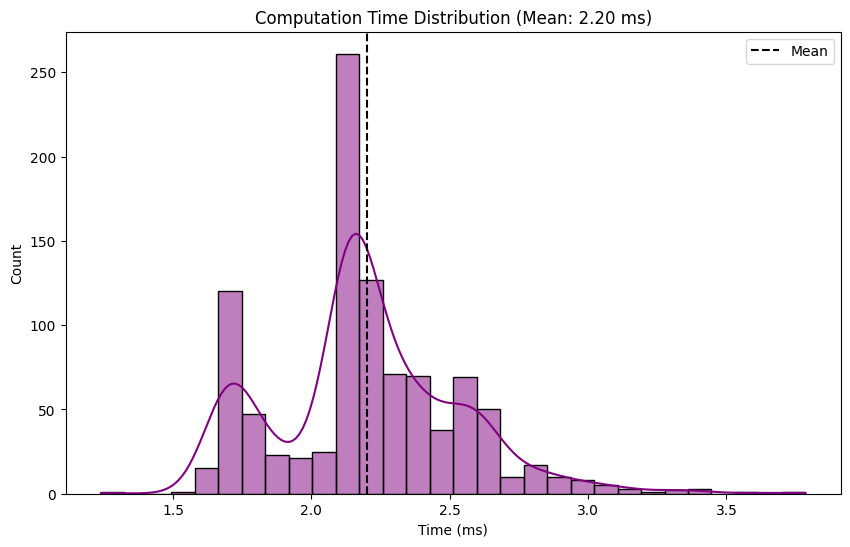

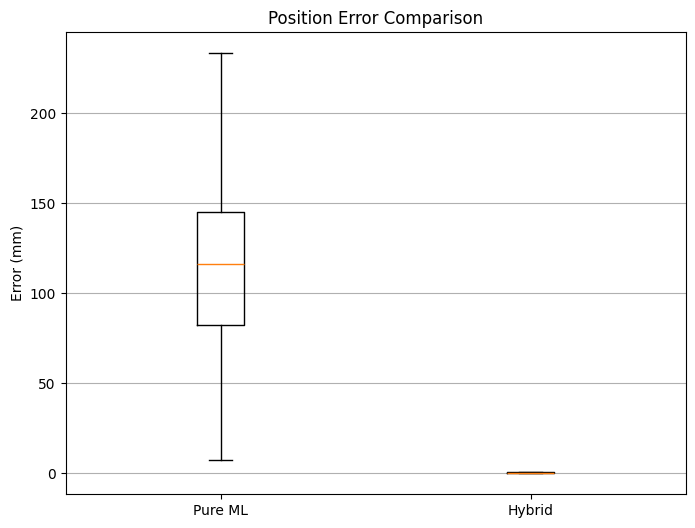

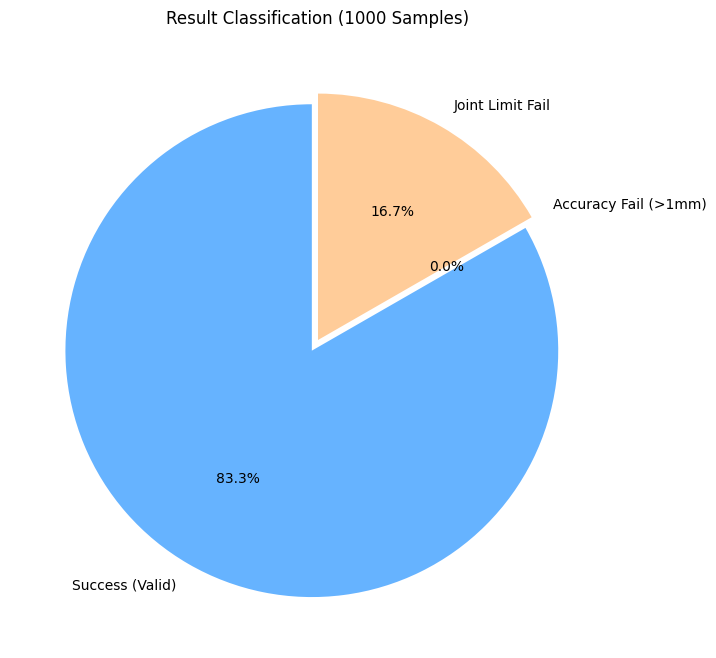

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def generate_final_plots():
    print("Loading Data (1000 samples)...")
    df = pd.read_csv(DATA_PATH).sample(1000, random_state=42) 
    solver = HybridIKSolver()
    
    results = []
    
    print("Running Batch Analysis...")
    for _, row in df.iterrows():
        target = row[['target_x', 'target_y', 'target_z', 'target_yaw', 'target_pitch', 'target_roll']].values
        current_q = row[['q1_in', 'q2_in', 'q3_in', 'q4_in', 'q5_in', 'q6_in']].values
        
        # 1. Hybrid Solve
        q_sol, info = solver.solve(target, current_q, tolerance=0.001, max_iter=50)
        
        # 2. Get Pure ML Error (for comparison)
        input_vec = np.concatenate([target, current_q])
        input_scaled = solver.scaler_x.transform([input_vec])
        pred_scaled = solver.model.predict(input_scaled)
        delta_ml = solver.scaler_y.inverse_transform(pred_scaled)[0]
        q_ml = current_q + delta_ml
        pos_ml = solver.robot.forward_kinematics(q_ml)
        info['ml_error_mm'] = np.linalg.norm(pos_ml - target[:3]) * 1000
        
        # Check Config Flip
        info['config_diff'] = np.linalg.norm(q_sol - current_q)
        
        results.append(info)

    res_df = pd.DataFrame(results)
    res_df['final_error_mm'] = res_df['final_error'] * 1000

    # --- PLOT 1: Speed Histogram ---
    plt.figure(figsize=(10, 6))
    sns.histplot(res_df['time'], bins=30, kde=True, color='purple')
    plt.title(f"Computation Time Distribution (Mean: {res_df['time'].mean():.2f} ms)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Count")
    plt.axvline(res_df['time'].mean(), color='k', linestyle='--', label='Mean')
    plt.legend()

    # --- PLOT 2: Accuracy Comparison (Boxplot) ---
    plt.figure(figsize=(8, 6))
    plt.boxplot([res_df['ml_error_mm'], res_df['final_error_mm']], labels=['Pure ML', 'Hybrid'], showfliers=False)
    plt.title("Position Error Comparison")
    plt.ylabel("Error (mm)")
    plt.grid(True, axis='y')

    # --- PLOT 3: Failure Analysis Pie Chart ---
    # Categories:
    # 1. Success (<1mm, Valid Limits)
    # 2. Accuracy Fail (>1mm)
    # 3. Limit Fail (<1mm but Invalid Limits)
    
    success_mask = (res_df['final_error_mm'] < 1.0) & (res_df['valid_limits'] == True)
    acc_fail_mask = (res_df['final_error_mm'] >= 1.0)
    limit_fail_mask = (res_df['final_error_mm'] < 1.0) & (res_df['valid_limits'] == False)
    
    counts = [success_mask.sum(), acc_fail_mask.sum(), limit_fail_mask.sum()]
    labels = ['Success (Valid)', 'Accuracy Fail (>1mm)', 'Joint Limit Fail']
    colors = ['#66b3ff', '#ff9999', '#ffcc99']
    
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, explode=(0.05, 0, 0))
    plt.title("Result Classification (1000 Samples)")

if __name__ == "__main__":
    generate_final_plots()